# A/B testing example

We are now going to practice with potentially the most common case you might face in the industry with A/B testing. The company has a website and would like to test what is the option that causes the highest conversion rate (paying/subscribing).

**Setup:** 
The company collected data from almost 300k users during January 2017. The users were shown randomly the new and the old version of the page. The company asks you to check if the new page increases the conversion rate (percentage of users who have completed the desired action, e.g. subscribing).

- This exercise session is based on: https://medium.com/towards-data-science/ab-testing-with-python-e5964dd66143
- Source dataset: https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv
- Another class based on those data: https://github.com/SadiqAlreemi/Analyze-AB-Test-Results
- Other AB testing dataset to play with: https://opendata.stackexchange.com/questions/6788/where-can-i-get-a-sample-dataset-for-a-b-split-testing


## 1. Variables selection

- **Central aspect**: This is A/B testing, and the "treatment" is randomly allocated. Therefore the causal effect can be measured by comparing the conversion rate between the control and treatment groups. 
- **outcome (converted):** dummy variable, taking the value 1 if the user subscribed.
- **explanatory variable (group):** categorical variable: control, or treatment.

In this setup, we want to test if the conversion rate (a proportion) with the treatment is higher than with the control. Formally we express this hypothesis:

$$H_0: p_0 \geq p_1$$
$$H_a: p_0 < p_1$$

with $p_0$, and $p_1$ respectively the conversion rate of the control and treatment group. $p_i=$(number of conversion among group $i$ / total number of individuals in group $i$).


## 2. Sample 
- *id:* user id
- *group:* control or treatment
- *converted:* dummy variable, taking the value 1 if the user subscribed, 0 otherwise

### 2.1 Sample size calculation
As we are going to see, the dataset is massive. Hence, we'll use this opportunity to compute the minimal sample size required and select randomly a sample based on this computation from the entire dataset (sample size calculation).

**a. Which statistical test are we going to use?**
As seen in the previous section, we are going to test the difference between the two proportions.

**b. information to compute the sample size:**
- Alternative hypothesis: unilateral
- $\alpha=0.05$ and $beta=0.8$ by convention
- *Effect size*: The marketing team estimated that the return on investment (implementing the change) is worth it if the difference is at least 5\%.
- *Standard deviation*: With the proportions difference test, you just need to feed the effect size (the sd is computed based on the proportion given the effect size).

**c. computing the sample size:**

In [1]:
# Packages imports
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import datetime

In [2]:
#import the data
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#How long lasted the experiment?
#Convert to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
#Check the span
print(df['timestamp'].min())
print(df['timestamp'].max())

2017-01-02 13:42:05.378582
2017-01-24 13:41:54.460509


In [4]:
#What is the proportion of converted with the current model (control)?
#We will use this as an estimate for the null effect.
df.loc[df['landing_page']=='old_page', 'converted'].mean()

0.12047759085568362

In [20]:
#Calculating effect size based on our expected rates
#The baseline conversion rate is 0.12. Hence the minimal effect size 0.12+0.05=0.17
effect_size = sms.proportion_effectsize(0.17, 0.12 )
#The effect size here is derived from Cohen's work: 2 * (arcsin(sqrt(prop1)) - arcsin(sqrt(prop2)))

print("The effect size is:")
print(effect_size)

sample_size = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

#Always round up to ensure that you have at least the expected power /!\
sample_size = ceil(sample_size)                                                 
print("Each group size should have a size of:")
print(sample_size)

#Or use Gpower: ztest>Proportions>A priori
#Fairly different estimates: 613 with Gpower (depends on the approximation method)

The effect size is:
0.14249435414546407
Each group size should have a size of:
774


### 2.2 Selecting the sample

With an actual experiment, you would setup your experiment and start collecing your data at this point. In our case, we will simply randomly select a sample from the full dataset. (Of course, this is just for the sake of the exercise. In real life, we would use all the data avaialable in order to increase the power.)

But first, let's clean the data.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [23]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In the dataset, there are surprisingly two columns that should be identical: landing_page and group.
The control group should see the old page and the treatment group the new_page.
Let's control that it's the case.

In [8]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Damned! Why do we have people in the control group who saw the new_page and the opposite as well?! In real life, I would discuss with the technical team what happened. Without more information and given the fact that the proportion of "errors" remains low, we will exclude those from the dataset. 

**/!\ IMPORTANT:** Exclusion of observations should always be documented!

A row in the dataset represents a user session. In order to prepare the sample we will:
1. Remove the errors spotted above (control seeing the new_page and the opposite)
2. Check if we have users with multiple sessions (remove them)
3. Look for missing variables
4. Randomly select the sample

In [9]:
#step 1
#Keep only if control is old page and treatment is new page
df_s=df.loc[((df['group']=='control') & (df['landing_page']=='old_page')) | 
            ((df['group']=='treatment') & (df['landing_page']=='new_page'))]
#check with a cross tab
pd.crosstab(df_s['group'], df_s['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [24]:
#step 2
session_counts = df['user_id'].value_counts()
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset.')

# Again, for simplicity we will drop those observations but in real-life it would be important to assess how to deal with those.
# Can we compare them to the others? Should we keep only the first instance or not?
# If we keep all of them, the independence assumption between observations would be violated.

There are 3894 users that appear multiple times in the dataset.


In [11]:
# Drop the users with multiple sessions
users_to_drop = session_counts[session_counts > 1].index

df_s = df_s[~df_s['user_id'].isin(users_to_drop)]
#note that "Python’s Tilde ~n operator is the bitwise negation operator". Hence ~0 is 1 and ~1 is 0.

print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 294478 entries


In [12]:
#step 3: missing values?
df_s.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [25]:
#step 4: select a random sample
#random_state=1234 set a seed for the random number generation and allows to replicate the results
control_sample = df_s[df_s['group'] == 'control'].sample(n=sample_size, random_state=1234)
treatment_sample = df_s[df_s['group'] == 'treatment'].sample(n=sample_size, random_state=1234)

ab_sample = pd.concat([control_sample, treatment_sample])
ab_sample.reset_index(drop=True, inplace=True)
#"inplace" modify directly ab_sample, "drop" will not include a column with the former index in the df.
ab_sample

,user_id,timestamp,group,landing_page,converted
0,772642,2017-01-20 14:15:39.989256,control,old_page,0
1,805427,2017-01-13 15:11:51.408191,control,old_page,0
2,640001,2017-01-05 12:32:18.803756,control,old_page,0
3,844691,2017-01-12 08:42:57.808665,control,old_page,0
4,819762,2017-01-11 14:06:23.083144,control,old_page,0
...,...,...,...,...,...
1543,631596,2017-01-14 04:05:36.784664,treatment,new_page,1
1544,803286,2017-01-02 16:00:47.578668,treatment,new_page,1
1545,828434,2017-01-13 10:55:09.881938,treatment,new_page,0
1546,759009,2017-01-23 16:32:37.952446,treatment,new_page,1


In [14]:
ab_sample['group'].value_counts()

control      774
treatment    774
Name: group, dtype: int64

## 3. Analysis
Let us first, use descriptive statistics (numerical, graphical) and then test statistically the difference.

In [15]:
ab_sample[['converted', 'group']].groupby('group').describe()

converted                                             
              count      mean       std  min  25%  50%  75%  max
group                                                           
control       774.0  0.114987  0.319213  0.0  0.0  0.0  0.0  1.0
treatment     774.0  0.145995  0.353329  0.0  0.0  0.0  0.0  1.0

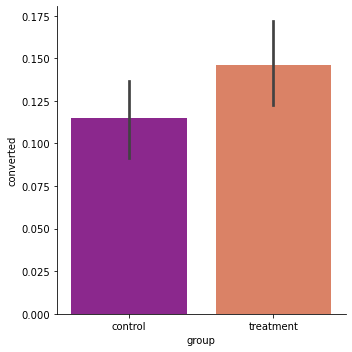

In [16]:
sns.catplot(x='group', y='converted', palette="plasma", kind='bar',  dodge=False, data=ab_sample)

The treatment group has a larger conversion rate. The difference is about 2.1 percentage points (less than half of 5%). Now let's test if the difference is statistically significant or not.

**Proportion test:** The two variables are Binomiale variables. But the Binomiale distribution is well approximated with a normal distribution: if $np ≥ 5$ and $n(1-p) ≥ 5$ (valid here). More information can be found here: https://online.stat.psu.edu/stat415/lesson/9/9.4. We are going to use the `proportions_ztest` from `statsmodels` to do the test. This module requires two pairs of information: \[number of successes in the control group, number of successes in the treatment group\] and \[number of observations in the control group, number of observations in the treatment group\].

In [26]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [28]:
control_results = ab_sample.loc[ab_sample['group'] == 'control','converted']
treatment_results = ab_sample.loc[ab_sample['group'] == 'treatment','converted']

In [36]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative='smaller')


print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
#(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
#print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
#print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.81
p-value: 0.035


**Conclusion:** The p-value is 0.035 which is smaller than the 5% threshold. Hence, we can reject the hypothesis that the control group has a higher conversion rate. The difference is "only" 3.1 percentage points, and hence a bit more than half of the minimal practical difference suggested by the marketing team (5%). What do you think the firm should do?